In [1]:
import pandas as pd
import numpy as np
import torch
import importlib
from utils.utils_dataset import prepare_k_fold_non_iid_dataset, plot_dataset_split, display_dataset_split
from sklearn import datasets
from sklearn.model_selection import KFold
from utils.utils_train import train_supervised, test_model
from utils.utils_plots import plot_first_feature_horizontal, save_figure
from utils.utils_metrics import calculate_metrics_statistics, calculate_cluster_stats, calculate_metrics, plot_confusion_matrix


In [2]:
from model.eGauss_plus import eGAUSSp

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)

# Check if CUDA is available
#if torch.cuda.is_available():
    #device = torch.device("cuda")
    #print("CUDA is available. Using GPU.")
#else:
device = torch.device("cpu")
print("CUDA not available. Using CPU.")

feature_dim = 4
num_classes = 3

# Model parameters
local_model_params = {
    "feature_dim": feature_dim,
    "num_classes": num_classes,
    "kappa_n": 1,
    "num_sigma": 1,
    "kappa_join": 0.5,
    "S_0": 1e-8,
    "N_r": 8,
    "c_max": 1000,
    "device": device
}
federated_model_params = {
    "feature_dim": feature_dim,
    "num_classes": num_classes,
    "kappa_n": 1,
    "num_sigma": 5,
    "kappa_join": 5,
    "S_0": 1e-8,
    "N_r": 8,
    "c_max": 1000,
    "device": device
}

PyTorch Version: 2.1.2
CUDA Version: None
CUDA not available. Using CPU.


In [3]:
# Load the Iris dataset
iris = datasets.load_iris()

X = iris.data
y = iris.target

num_clients = 4
num_splits = 5
num_repetitions = 10

# Re-inserting the repetition of the experiment 10 times
experiment_results = []
for experiment in range(num_repetitions):
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=None)

    # Initialize arrays to track samples per class for each client in each fold
    samples_per_class_per_client = np.zeros((num_clients, local_model_params["num_classes"], num_splits))

    # Main loop for k-fold cross-validation
    all_client_metrics = [[] for _ in range(num_clients)]
    all_client_clusters = [[] for _ in range(num_clients)]

    all_federated_metrics = []
    all_federated_clusters = []

    for i_fold, (train_index, test_index) in enumerate(kf.split(iris.data)):
        # Split the data
        train_data, test_data, all_data = prepare_k_fold_non_iid_dataset(X, y, train_index, test_index, num_clients)

        # Create the models
        local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
        federated_model = eGAUSSp(**federated_model_params)

        # Train and test the models
        for client_idx, client_model in enumerate(local_models):
            # Count the number of samples per class for this client in this fold
            for class_idx in range(client_model.num_classes):
                class_samples = torch.sum((train_data[client_idx][1] == class_idx).float(), dim=0)
                samples_per_class_per_client[client_idx, class_idx, i_fold] = class_samples

            # Supervised clustering
            train_supervised(client_model, train_data[client_idx])

            # Test the local models
            _, pred, _ = test_model(client_model, test_data)
            metrics = calculate_metrics(pred, test_data, "weighted")
            all_client_metrics[client_idx].append(metrics)

            # Save the number of clusters
            num_client_clusters = torch.sum(client_model.n[:client_model.c] > 1)
            all_client_clusters[client_idx].append(num_client_clusters)

        # Aggregate local models
        for client_model in local_models:
            federated_model.federal_agent.merge_model_privately(client_model, federated_model.kappa_n)

        federated_model.federal_agent.federated_merging()

        num_federated_clusters = torch.sum(federated_model.n[:federated_model.c] > 0)
        all_federated_clusters.append(num_federated_clusters)

        # Test the federated model
        _, pred_fed, _ = test_model(federated_model, test_data)
        federated_metrics = calculate_metrics(pred_fed, test_data, "weighted")
        all_federated_metrics.append(federated_metrics)

    # Store results of each experiment
    experiment_results.append({
        "client_metrics": all_client_metrics,
        "client_clusters": all_client_clusters,
        "federated_metrics": all_federated_metrics,
        "federated_clusters": all_federated_clusters,
        "samples_per_class_per_client": samples_per_class_per_client
    })
    
# Displaying the result of the first experiment for brevity
experiment_results[0]  # Replace with desired processing or analysis of experiment results



Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.

c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.


{'client_metrics': [[{'accuracy': 0.3,
    'precision': 0.175,
    'recall': 0.3,
    'f1_score': 0.2090909090909091},
   {'accuracy': 0.6,
    'precision': 0.6181818181818183,
    'recall': 0.6,
    'f1_score': 0.5477272727272726},
   {'accuracy': 0.5333333333333333,
    'precision': 0.43888888888888894,
    'recall': 0.5333333333333333,
    'f1_score': 0.43607843137254904},
   {'accuracy': 0.4666666666666667,
    'precision': 0.4222222222222222,
    'recall': 0.4666666666666667,
    'f1_score': 0.4047619047619048},
   {'accuracy': 0.6333333333333333,
    'precision': 0.5518341307814992,
    'recall': 0.6333333333333333,
    'f1_score': 0.5680076628352491}],
  [{'accuracy': 0.7,
    'precision': 0.58,
    'recall': 0.7,
    'f1_score': 0.6142857142857143},
   {'accuracy': 0.5333333333333333,
    'precision': 0.31635610766045547,
    'recall': 0.5333333333333333,
    'f1_score': 0.3866355866355866},
   {'accuracy': 0.6666666666666666,
    'precision': 0.48611111111111105,
    'recall':

In [4]:
import numpy as np

# Initialize variables to store aggregated data
agg_client_metrics = [{} for _ in range(num_clients)]
agg_federated_metrics = {}
agg_client_clusters = [[] for _ in range(num_clients)]
agg_federated_clusters = []

# Process each experiment
for result in experiment_results:
    for client_idx, client_metrics in enumerate(result['client_metrics']):
        for metric in client_metrics[0].keys():
            if metric not in agg_client_metrics[client_idx]:
                agg_client_metrics[client_idx][metric] = []
            agg_client_metrics[client_idx][metric].extend([m[metric] for m in client_metrics])

    for metric in result['federated_metrics'][0].keys():
        if metric not in agg_federated_metrics:
            agg_federated_metrics[metric] = []
        agg_federated_metrics[metric].extend([m[metric] for m in result['federated_metrics']])

    for client_idx, client_clusters in enumerate(result['client_clusters']):
        agg_client_clusters[client_idx].extend(client_clusters)

    agg_federated_clusters.extend(result['federated_clusters'])

# Calculate averages and standard deviations
for client_metrics in agg_client_metrics:
    for metric, values in client_metrics.items():
        mean = np.mean(values)
        std = np.std(values, ddof=1)
        client_metrics[metric] = (mean, std)

for metric, values in agg_federated_metrics.items():
    mean = np.mean(values)
    std = np.std(values, ddof=1)
    agg_federated_metrics[metric] = (mean, std)

# Example of printing aggregated metrics for the first client
print("Aggregated Metrics for Client 1:")
for metric, (mean, std) in agg_client_metrics[0].items():
    print(f"{metric}: {mean:.2f} ± {std:.2f}")

agg_samples = np.zeros((num_clients, num_classes, num_splits))

# Aggregate data from each experiment
for result in experiment_results:
    samples_per_class_per_client = result['samples_per_class_per_client']
    agg_samples += samples_per_class_per_client

# Compute the average across all repetitions (and folds if required)
avg_samples = agg_samples / len(experiment_results)

# Calculate the average for each client and class across folds
avg_samples_per_class_per_client = avg_samples.mean(axis=2)

# Print the results
for client_idx in range(num_clients):
    print(f"Client {client_idx + 1}:")
    for class_idx in range(num_classes):
        avg_samples = avg_samples_per_class_per_client[client_idx, class_idx]
        print(f"  Class {class_idx}: {avg_samples:.2f} samples")

Aggregated Metrics for Client 1:
accuracy: 0.56 ± 0.10
precision: 0.45 ± 0.10
recall: 0.56 ± 0.10
f1_score: 0.47 ± 0.10
Client 1:
  Class 0: 0.00 samples
  Class 1: 10.06 samples
  Class 2: 10.64 samples
Client 2:
  Class 0: 19.94 samples
  Class 1: 0.00 samples
  Class 2: 9.96 samples
Client 3:
  Class 0: 9.92 samples
  Class 1: 19.72 samples
  Class 2: 9.76 samples
Client 4:
  Class 0: 10.14 samples
  Class 1: 10.22 samples
  Class 2: 9.64 samples


In [5]:
# Create a LaTeX table for the paper
# Start the LaTeX table code
latex_table = r"""\begin{table}[ht]
\centering
\setlength{\tabcolsep}{2pt}
\scriptsize
\caption{Performance metrics and average number of clusters on the Iris dataset.}
\label{tab:performance_clusters}
\begin{tabular}{lcccccc}
\toprule
\textbf{Metric} & \textbf{Client 1} & \textbf{Client 2} & \textbf{Client 3} & \textbf{Client 4} & \textbf{Federated} \\
"""

# Add the header for average samples per class
latex_table += r"Average Samples &"

# Add the average samples per class for each client
samples_row = ""
for samples in avg_samples_per_class_per_client:
    samples_row += " & " + "/".join([f"{x:.1f}" for x in samples])
latex_table += samples_row + " \\\\" + "\n"

latex_table += r"\midrule" + "\n"


# Add rows for each metric
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
metric_names = ['Accuracy (\%)', 'Precision (\%)', 'Recall (\%)', 'F1 Score (\%)']
for i, metric in enumerate(metrics):
    row = metric_names[i] + r' $\uparrow$'
    for client_metrics in agg_client_metrics:
        mean, std = client_metrics[metric]
        row += f' & {mean * 100:.1f} ± {std * 100:.1f}'
    mean, std = agg_federated_metrics[metric]
    row += r' & \bf' + f'{{{mean * 100:.1f} ± {std * 100:.1f}}}'
    latex_table += row + r' \\' + '\n'

# Add row for clusters
cluster_row = r'\#Clusters $\downarrow$'
for client_clusters in agg_client_clusters:
    avg_clusters = np.mean(client_clusters)
    std_clusters = np.std(client_clusters, ddof=1)
    cluster_row += f' & {avg_clusters:.1f} ± {std_clusters:.1f}'

# Assuming agg_federated_clusters is a list of cluster counts for the federated model
avg_fed_clusters = np.mean(agg_federated_clusters)
std_fed_clusters = np.std(agg_federated_clusters, ddof=1)
cluster_row += r' & \bf' + f'{{{avg_fed_clusters:.1f} ± {std_fed_clusters:.1f}}}'

latex_table += cluster_row + r' \\' + '\n'

# End the LaTeX table code
latex_table += r"""\bottomrule
\end{tabular}
\end{table}
"""

# Print the complete LaTeX table
print(latex_table)


\begin{table}[ht]
\centering
\setlength{\tabcolsep}{2pt}
\scriptsize
\caption{Performance metrics and average number of clusters on the Iris dataset.}
\label{tab:performance_clusters}
\begin{tabular}{lcccccc}
\toprule
\textbf{Metric} & \textbf{Client 1} & \textbf{Client 2} & \textbf{Client 3} & \textbf{Client 4} & \textbf{Federated} \\
Average Samples & & 0.0/10.1/10.6 & 19.9/0.0/10.0 & 9.9/19.7/9.8 & 10.1/10.2/9.6 \\
\midrule
Accuracy (\%) $\uparrow$ & 56.2 ± 10.1 & 66.2 ± 9.2 & 79.9 ± 9.9 & 81.5 ± 9.0 & \bf{91.3 ± 6.3} \\
Precision (\%) $\uparrow$ & 45.4 ± 9.8 & 49.0 ± 11.5 & 84.0 ± 10.7 & 85.0 ± 8.0 & \bf{93.2 ± 4.7} \\
Recall (\%) $\uparrow$ & 56.2 ± 10.1 & 66.2 ± 9.2 & 79.9 ± 9.9 & 81.5 ± 9.0 & \bf{91.3 ± 6.3} \\
F1 Score (\%) $\uparrow$ & 47.3 ± 10.2 & 55.0 ± 11.1 & 78.3 ± 11.9 & 80.7 ± 9.7 & \bf{91.1 ± 6.6} \\
\#Clusters $\downarrow$ & 5.6 ± 1.1 & 4.7 ± 1.1 & 6.2 ± 1.2 & 5.9 ± 1.7 & \bf{3.2 ± 0.4} \\
\bottomrule
\end{tabular}
\end{table}



Client 1: {1: 7, 2: 11}
Client 2: {0: 23, 2: 11}
Client 3: {0: 8, 1: 22, 2: 8}
Client 4: {0: 9, 1: 14, 2: 7}
Test Set: {0: 10, 1: 7, 2: 13}

Combined Number of Samples per Class:
Class 0: 50 samples
Class 1: 50 samples
Class 2: 50 samples

Total Number of Samples Across All Datasets: 150
Figure saved as Images/iris_data_distribution.svg in svg format.


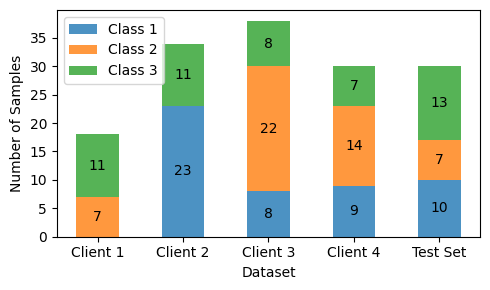

In [6]:
#Aditional plots of the data
display_dataset_split(train_data, test_data)
fig = plot_dataset_split(train_data, test_data)
save_figure(fig, "Images/iris_data_distribution.svg","svg")

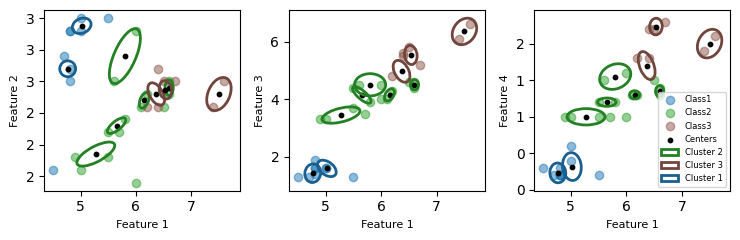

Figure saved as Images/iris_local_model.svg in svg format.
Figure saved as Images/iris_local_model.pdf in pdf format.


In [7]:
#Plot of the last local model
fig = plot_first_feature_horizontal(train_data[client_idx], model=client_model, num_sigma=2, N_max=1, title="",format='%d', legend = True, data_name = "Class")  
save_figure(fig, "Images/iris_local_model.svg", "svg")
save_figure(fig, "Images/iris_local_model.pdf","pdf")

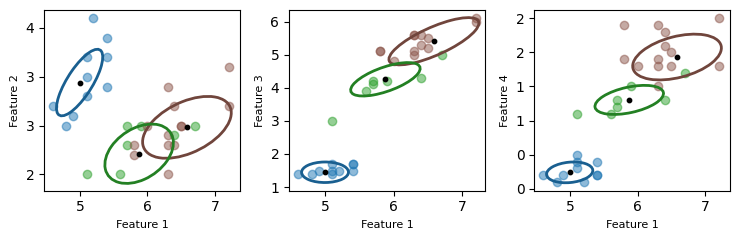

Number of clusters after merging = 3
Figure saved as Images/iris_federated_merged.svg in svg format.
Figure saved as Images/iris_federated_merged.pdf in pdf format.


In [8]:
#Plot of the last federated model
fig = plot_first_feature_horizontal(test_data, model=federated_model, num_sigma=2, N_max=0, title="", format='%d')   
print(f"Number of clusters after merging = {federated_model.c}")
save_figure(fig, "Images/iris_federated_merged.svg","svg")
save_figure(fig, "Images/iris_federated_merged.pdf","pdf")

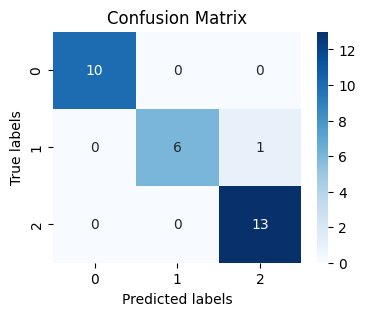

In [9]:
plot_confusion_matrix(pred_fed, test_data)